In [ ]:
        filestr = file.read()
        img = Image.open(file)
        img = np.array(img)
        img = cv2.resize(img,(224,224))

In [1]:
import cv2
import io
import numpy as np
from tqdm import tqdm
from glob import glob
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing import image
from PIL import Image

ResNet50_model = ResNet50(weights='imagenet')
ResNet50_model_base = ResNet50(weights='imagenet', include_top=False)
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

model_classifier = Sequential()
model_classifier.add(GlobalAveragePooling2D(input_shape = ResNet50_model_base.output_shape[1:]))
model_classifier.add(Dense(133, activation = 'softmax'))
model_classifier.load_weights('saved_models/weights.best.Resnet50.hdf5')

# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    #img = cv2.imread(img_path)
    in_memory_file = io.BytesIO()
    file.save(in_memory_file)
    data = np.fromstring(in_memory_file.getvalue(), dtype=np.uint8)
    color_image_flag = 1
    img = cv2.imdecode(data, color_image_flag)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0
def path_to_tensor(img_path):
    img = Image.open(img_path)
    img = np.array(img)
    img = cv2.resize(img,(224,224))
    return np.expand_dims(x, axis=0)

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    print(img.shape)
    return np.argmax(ResNet50_model.predict(img))

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def extract_Resnet50(tensor):
    return ResNet50_model_base.predict(preprocess_input(tensor))

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = model_classifier.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def classify_dog_or_human(img_path):
    result = ""
    if(dog_detector(img_path)):
        result += "There is a dog on your image. "
        breed = Resnet50_predict_breed(img_path)
        result += "Possible breed is " + breed
    elif(face_detector2(img_path)):
        result += "There is a human on your image. If this human was a dog, he would look like "
        breed = Resnet50_predict_breed(img_path)
        result += breed
    else:
        result += "This image does not contain any human or dog!"
    return result

Using TensorFlow backend.


In [1]:
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing import image

Using TensorFlow backend.


In [9]:
ResNet50_model = ResNet50(weights='imagenet')
ResNet50_model_base = ResNet50(weights='imagenet', include_top=False)
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]


# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    print(x.shape)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    print(img)
    return np.argmax(ResNet50_model.predict(img))

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def extract_Resnet50(tensor):
    return ResNet50_model_base.predict(preprocess_input(tensor))

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = model_classifier.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def classify_dog_or_human(img_path):
    if(dog_detector(img_path)):
        print("Dog detected! Predicting breed...")
        return Resnet50_predict_breed(img_path)
    elif(face_detector2(img_path)):
        print("Human detected! Predicting possible breed...")
        return Resnet50_predict_breed(img_path)
    else:
        print("This image does not contain any human or dog!")

In [21]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def extract_Resnet50(tensor):
    return ResNet50_model_base.predict(preprocess_input(tensor))

model_classifier = Sequential()
model_classifier.add(GlobalAveragePooling2D(input_shape = ResNet50_model_base.output_shape[1:]))
model_classifier.add(Dense(133, activation = 'softmax'))
model_classifier.load_weights('saved_models/weights.best.Resnet50.hdf5')

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = model_classifier.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def classify_dog_or_human(img_path):
    if(dog_detector(img_path)):
        print("Dog detected! Predicting breed...")
        return Resnet50_predict_breed(img_path)
    elif(face_detector(img_path)):
        print("Human detected! Predicting possible breed...")
        return Resnet50_predict_breed(img_path)
    else:
        print("This image does not contain any human or dog!")

In [4]:
import matplotlib.pyplot as plt
def show_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

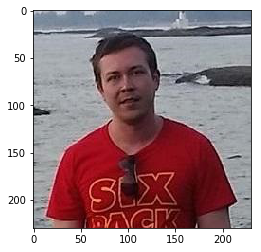

In [5]:
img_path = 'test_images/human_me.jpg'
show_image(img_path)

In [10]:
classify_dog_or_human(img_path)

(224, 224, 3)
[[[[  97.06099701   73.22100067   62.31999969]
   [ 104.06099701   80.22100067   69.31999969]
   [ 105.06099701   81.22100067   70.31999969]
   ..., 
   [  35.06099701    6.22100067  -16.68000031]
   [  35.06099701    6.22100067  -16.68000031]
   [  35.06099701    6.22100067  -16.68000031]]

  [[  94.06099701   69.22100067   58.31999969]
   [ 102.06099701   77.22100067   66.31999969]
   [ 102.06099701   77.22100067   66.31999969]
   ..., 
   [  33.06099701    4.22100067  -18.68000031]
   [  33.06099701    4.22100067  -18.68000031]
   [  33.06099701    4.22100067  -18.68000031]]

  [[ 104.06099701   77.22100067   64.31999969]
   [ 106.06099701   79.22100067   66.31999969]
   [  99.06099701   72.22100067   59.31999969]
   ..., 
   [  34.06099701    2.22100067  -19.68000031]
   [  34.06099701    2.22100067  -19.68000031]
   [  34.06099701    2.22100067  -19.68000031]]

  ..., 
  [[  54.06099701   38.22100067   26.31999969]
   [  41.06099701   25.22100067   13.31999969]
   [ 

NameError: name 'face_detector2' is not defined

In [ ]:
import os
import numpy as np
from io import BytesIO
from keras.preprocessing import image
import cv2
from flask import Flask, request, redirect, url_for
from werkzeug.utils import secure_filename
UPLOAD_FOLDER = 'C:/Lab/'
ALLOWED_EXTENSIONS = set(['txt', 'pdf', 'png', 'jpg', 'jpeg', 'gif'])
from flask import Flask, render_template
import main
app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/upload', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        print(request.files['file'])
        file = request.files['file']
        filename = secure_filename(file.filename)
        #img = PIL.Image.open(file)
        breed = ''
        global graph
        with graph.as_default():
            breed = main.classify_dog_or_human(file)
        return breed
    return "Error"

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS
if __name__ == '__main__':
    app.run(debug = True)